In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('nonlinear_selected_features.xlsx')

training_df.head()

,355,510,669,1894,1898,2023,2025,2028,2031,Water Potential (Mpa)
0,0.1073,0.0976,0.0513,0.0678,0.0574,0.0702,0.0717,0.0740,0.0763,-0.089632
1,0.0666,0.0691,0.0522,0.0855,0.0757,0.0868,0.0887,0.0904,0.0919,-0.148237
2,0.0624,0.0388,0.0239,0.0533,0.0459,0.0534,0.0549,0.0561,0.0573,-0.128243
3,0.0874,0.0659,0.0448,0.0831,0.0734,0.0808,0.0827,0.0846,0.0861,-0.164785
4,0.0666,0.0394,0.0328,0.0662,0.0573,0.0653,0.0669,0.0683,0.0702,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 16:25:15,810] A new study created in memory with name: no-name-dada4d42-4224-474c-94f2-e988228c1254
[I 2024-03-07 16:25:15,828] Trial 0 finished with value: 2.4443401863902947 and parameters: {'n_components': 9, 'max_iter': 518}. Best is trial 0 with value: 2.4443401863902947.
[I 2024-03-07 16:25:15,838] Trial 1 finished with value: 1.8698768146691478 and parameters: {'n_components': 2, 'max_iter': 624}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:15,848] Trial 2 finished with value: 2.4994136236943323 and parameters: {'n_components': 6, 'max_iter': 716}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:15,867] Trial 3 finished with value: 2.5424250406495372 and parameters: {'n_components': 1, 'max_iter': 771}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:15,876] Trial 4 finished with value: 2.0514303338602384 and parameters: {'n_components': 3, 'max_iter': 778}. Best is trial 1 with value: 1.86987681466914

[I 2024-03-07 16:25:18,809] Trial 46 finished with value: 2.5424250406495372 and parameters: {'n_components': 1, 'max_iter': 108}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:18,882] Trial 47 finished with value: 1.8698768146691478 and parameters: {'n_components': 2, 'max_iter': 371}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:18,965] Trial 48 finished with value: 2.0514303338602384 and parameters: {'n_components': 3, 'max_iter': 571}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:19,051] Trial 49 finished with value: 2.5424250406495372 and parameters: {'n_components': 1, 'max_iter': 513}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:19,110] Trial 50 finished with value: 2.5762185247349394 and parameters: {'n_components': 4, 'max_iter': 651}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:19,185] Trial 51 finished with value: 1.8698768146691478 and parameters: {'n_componen

[I 2024-03-07 16:25:22,151] Trial 92 finished with value: 1.8698768146691478 and parameters: {'n_components': 2, 'max_iter': 738}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:22,229] Trial 93 finished with value: 1.8698768146691478 and parameters: {'n_components': 2, 'max_iter': 792}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:22,292] Trial 94 finished with value: 2.5424250406495372 and parameters: {'n_components': 1, 'max_iter': 654}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:22,364] Trial 95 finished with value: 2.0514303338602384 and parameters: {'n_components': 3, 'max_iter': 693}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:22,424] Trial 96 finished with value: 1.8698768146691478 and parameters: {'n_components': 2, 'max_iter': 603}. Best is trial 1 with value: 1.8698768146691478.
[I 2024-03-07 16:25:22,499] Trial 97 finished with value: 1.8698768146691478 and parameters: {'n_componen

Number of finished trials:  100
Best trial:
  Value: 1.8698768146691478
  Params: 
    n_components: 2
    max_iter: 624
Mean Squared Error: 1.8698768146691478
Root Mean Squared Error: 1.3674343913581914
R-Squared value: 0.535499955317047


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
355: 0.25019124281235955
510: 0.24509714842896133
1898: -0.20658816389569154


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 16:25:22,814] A new study created in memory with name: no-name-c40bfba7-4951-4460-8fed-fb9e5cbda51c
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:22,827] Trial 0 finished with value: 4.832641079910804 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 4.832641079910804.
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:23,057] Trial 10 finished with value: 2.2594457797870393 and parameters: {'alpha': 0.27682391622961355, 'l1_ratio': 0.06343733200190918, 'max_iter': 457}. Best is trial 7 with value: 2.1658261026797105.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:23,680] Trial 19 finished with value: 3.7081842037864496 and parameters: {'alpha': 0.6358093190809075, 'l1_ratio': 0.38182654574068653, 'max_iter': 547}. Best is trial 14 with value: 2.0479928433288177.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-03-07 16:25:24,423] Trial 28 finished with value: 2.303977834866416 and parameters: {'alpha': 0.4106861216022109, 'l1_ratio': 0.016819875882105984, 'max_iter': 804}. Best is trial 14 with value: 2.0479928433288177.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:24,488] Trial 29 finished with value: 4.802279157525988 and parameters: {'alpha': 0.9668894200089733, 'l1_ratio

[I 2024-03-07 16:25:25,385] Trial 38 finished with value: 2.4558532967080957 and parameters: {'alpha': 0.15037732890489322, 'l1_ratio': 0.5106451257723654, 'max_iter': 650}. Best is trial 14 with value: 2.0479928433288177.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:25,491] Trial 39 finished with value: 2.057506000166291 and parameters: {'alpha': 0.04564610235619748, 'l1_rati

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:26,473] Trial 48 finished with value: 2.343808371283417 and parameters: {'alpha': 0.0908177265796322, 'l1_ratio': 0.838630566596638, 'max_iter': 781}. Best is trial 14 with value: 2.0479928433288177.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated i

[I 2024-03-07 16:25:27,701] Trial 57 finished with value: 2.252103386677583 and parameters: {'alpha': 0.10153167158438421, 'l1_ratio': 0.4110673777980808, 'max_iter': 309}. Best is trial 50 with value: 2.0391207374014555.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:27,788] Trial 58 finished with value: 4.603121053847858 and parameters: {'alpha': 0.6951986144597379, 'l1_ratio'

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:28,609] Trial 67 finished with value: 2.044897921726604 and parameters: {'alpha': 0.03218949894488195, 'l1_ratio': 0.48305077385575834, 'max_iter': 237}. Best is trial 59 with value: 2.0351846257752264.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-03-07 16:25:29,997] Trial 76 finished with value: 2.5833784606192993 and parameters: {'alpha': 0.15728248531487835, 'l1_ratio': 0.6869733409326174, 'max_iter': 142}. Best is trial 73 with value: 2.0277586031142922.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Object

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:31,117] Trial 85 finished with value: 2.21585836913008 and parameters: {'alpha': 0.07159207847112653, 'l1_ratio': 0.6739881928698458, 'max_iter': 286}. Best is trial 81 with value: 2.0268511582647775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 16:25:32,247] Trial 93 finished with value: 2.2856044961994773 and parameters: {'alpha': 0.11128441384740864, 'l1_ratio': 0.42013499818227296, 'max_iter': 157}. Best is trial 81 with value: 2.0268511582647775.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/3317287144.py:7: FutureWarning: suggest_uniform has been deprecat

Number of finished trials:  100
Best trial:
  Value: 2.0268511582647775
  Params: 
    alpha: 0.02272904056583229
    l1_ratio: 0.7706679983127642
    max_iter: 157
Mean Squared Error: 2.0268511582647775
Root Mean Squared Error: 1.4236752292095194
R-Squared value: 0.4965056274328603


/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e-02, tolerance: 6.230e-03
  model = cd_fast.enet_coordinate_descent(


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
1894: -0.7026334377402033
1898: -0.2605969197464566
510: 0.24183813675619922


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 16:25:33,042] A new study created in memory with name: no-name-29d842e4-b686-452a-b882-611a191d947f
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:33,078] Trial 0 finished with value: 6.991012681519895 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 6.991012681519895.
/var/folder

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:33,256] Trial 10 finished with value: 3.975248223275093 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 3.975248223275093.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has be

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:33,680] Trial 19 finished with value: 2.154277776590648 and parameters: {'alpha': 0.10278682254016053, 'gamma': 0.10094886874103906, 'kernel': 'rbf'}. Best is trial 19 with value: 2.154277776590648.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has be

[I 2024-03-07 16:25:34,127] Trial 28 finished with value: 9.399704624119847 and parameters: {'alpha': 0.36253187184403357, 'gamma': 2.0064699023043966, 'kernel': 'rbf'}. Best is trial 25 with value: 1.7888732671088243.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:34,216] Trial 29 finished with value: 10.249365477353036 and parameters: {'alpha': 0.9668894200089733

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:34,881] Trial 39 finished with value: 7.355114185386358 and parameters: {'alpha': 0.4206700839292816, 'gamma': 0.49725522433344005, 'kernel': 'rbf'}. Best is trial 25 with value: 1.7888732671088243.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:35,376] Trial 49 finished with value: 10.249366130513868 and parameters: {'alpha': 0.1478886077927642, 'gamma': 85498.63588704451, 'kernel': 'rbf'}. Best is trial 25 with value: 1.7888732671088243.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been d

[I 2024-03-07 16:25:35,879] Trial 58 finished with value: 6.870554595390477 and parameters: {'alpha': 0.1801926544438398, 'gamma': 0.0452960485558796, 'kernel': 'linear'}. Best is trial 56 with value: 1.7370148914344494.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:35,945] Trial 59 finished with value: 4.473720853389636 and parameters: {'alpha': 0.071910014686163

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:36,553] Trial 69 finished with value: 3.029568174469152 and parameters: {'alpha': 0.5674155828217603, 'gamma': 0.06326415974458253, 'kernel': 'rbf'}. Best is trial 65 with value: 1.734904926280367.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been d

[I 2024-03-07 16:25:37,127] Trial 78 finished with value: 6.647076840243777 and parameters: {'alpha': 0.20989851772312226, 'gamma': 0.4306606005694419, 'kernel': 'rbf'}. Best is trial 65 with value: 1.734904926280367.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:37,164] Trial 79 finished with value: 2.1817723526887365 and parameters: {'alpha': 0.09799581357932084

[I 2024-03-07 16:25:37,751] Trial 88 finished with value: 1.9737183826397489 and parameters: {'alpha': 0.08997686838140086, 'gamma': 0.08762501177265886, 'kernel': 'rbf'}. Best is trial 65 with value: 1.734904926280367.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:37,854] Trial 89 finished with value: 1.749349824673647 and parameters: {'alpha': 0.0628917377323104

[I 2024-03-07 16:25:38,314] Trial 98 finished with value: 2.267908220730221 and parameters: {'alpha': 0.0005725650281848405, 'gamma': 0.00044923376951256294, 'kernel': 'rbf'}. Best is trial 65 with value: 1.734904926280367.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 16:25:38,353] Trial 99 finished with value: 1.8246880324420889 and parameters: {'alpha': 0.02891826912

Number of finished trials:  100
Best trial:
  Value: 1.734904926280367
  Params: 
    alpha: 0.031572005623362875
    gamma: 0.05765004621074228
    kernel: rbf
Mean Squared Error: 1.734904926280367
Root Mean Squared Error: 1.3171578972470868
R-Squared value: 0.5690286068815213


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
1894: 910.1975419798582
669: 452.48856751928156
2031: 298.7677154878912


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 2


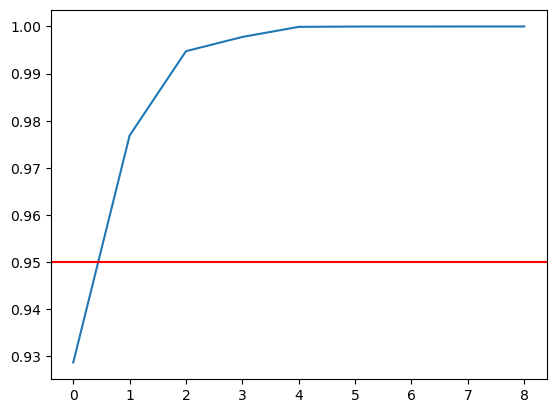

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 1.8828470328802567
Root Mean Squared Error: 1.3721687333853139
R-Squared value: 0.5322779960460702


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
355: 0.4940840844691294
510: 0.3708200595247426
669: 0.1881880776231295


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 16:25:39,396] A new study created in memory with name: no-name-90c497b8-ade5-446a-804d-d56c4283ed0e
[I 2024-03-07 16:25:40,140] Trial 0 finished with value: 4.49861210394971 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 4.49861210394971.
[I 2024-03-07 16:25:40,622] Trial 1 finished with value: 4.820447071889042 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 4.49861210394971.
[I 2024-03-07 16:25:40,946] Trial 2 finished with value: 4.611131183844791 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 4.49861210394971.
[I 2024-03-07 16:25:41,283] Trial 3 finished with value: 3.3968249245622757 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 3.396824

[I 2024-03-07 16:25:53,992] Trial 36 finished with value: 2.8067515924439905 and parameters: {'n_estimators': 93, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 35 with value: 1.6699175028471813.
[I 2024-03-07 16:25:54,370] Trial 37 finished with value: 4.706526047582481 and parameters: {'n_estimators': 81, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 35 with value: 1.6699175028471813.
[I 2024-03-07 16:25:54,889] Trial 38 finished with value: 3.682535141435764 and parameters: {'n_estimators': 118, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 35 with value: 1.6699175028471813.
[I 2024-03-07 16:25:55,513] Trial 39 finished with value: 1.9749255565014527 and parameters: {'n_estimators': 139, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 35 with value: 1.6699175028471813.
[I 2024-03-07 16:25:55,846] Trial 40 finished with value: 2.8582371076676556 and parame

[I 2024-03-07 16:26:11,638] Trial 72 finished with value: 1.9060435244120946 and parameters: {'n_estimators': 61, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 63 with value: 1.4345246402620841.
[I 2024-03-07 16:26:12,051] Trial 73 finished with value: 1.371842121419853 and parameters: {'n_estimators': 66, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 73 with value: 1.371842121419853.
[I 2024-03-07 16:26:12,677] Trial 74 finished with value: 2.2927952150487725 and parameters: {'n_estimators': 68, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 73 with value: 1.371842121419853.
[I 2024-03-07 16:26:13,238] Trial 75 finished with value: 1.8717326413435555 and parameters: {'n_estimators': 71, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 73 with value: 1.371842121419853.
[I 2024-03-07 16:26:13,600] Trial 76 finished with value: 1.5619410195259773 and parameters:

Best trial:
  Value: 1.371842121419853
  Params: 
    n_estimators: 66
    max_depth: 21
    min_samples_split: 2
    min_samples_leaf: 1
Mean Squared Error: 1.869880829075279
Root Mean Squared Error: 1.3674358592180034
R-Squared value: 0.5354989580899501


In [15]:
# Get feature importances from the trained RandomForestRegressor model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1894: 0.19674511895777158
355: 0.1761173748742399
1898: 0.15787941919253973


## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-03-07 16:26:30,450] A new study created in memory with name: no-name-113acdaa-6b3a-4311-8441-bd3e8678c523
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:30,920] Trial 0 finished with value: 0.7272494098278766 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 0.7272494098278766.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:34,772] Trial 14 finished with value: 1.020317666406485 and parameters: {'n_estimators': 83, 'max_depth': 3, 'learning_rate': 0.05398876802687702}. Best is trial 11 with value: 0.40769773345958193.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:35,092] Trial 15 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:39,255] Trial 28 finished with value: 0.7566844025582248 and parameters: {'n_estimators': 55, 'max_depth': 4, 'learning_rate': 0.06753044509483017}. Best is trial 11 with value: 0.40769773345958193.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:39,695] Trial 29 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:45,321] Trial 42 finished with value: 0.471551694337575 and parameters: {'n_estimators': 127, 'max_depth': 5, 'learning_rate': 0.03829209999742417}. Best is trial 11 with value: 0.40769773345958193.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:45,983] Trial 43 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:51,497] Trial 56 finished with value: 0.8157137259136081 and parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.05895192133032205}. Best is trial 11 with value: 0.40769773345958193.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:51,944] Trial 57

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:56,795] Trial 70 finished with value: 0.7978013095082664 and parameters: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.0976336234692973}. Best is trial 11 with value: 0.40769773345958193.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:26:57,206] Trial 71 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:27:02,445] Trial 84 finished with value: 0.5378068417554286 and parameters: {'n_estimators': 144, 'max_depth': 5, 'learning_rate': 0.08825269500592708}. Best is trial 11 with value: 0.40769773345958193.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:27:02,796] Trial 85

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:27:07,547] Trial 98 finished with value: 0.34055213521842065 and parameters: {'n_estimators': 148, 'max_depth': 5, 'learning_rate': 0.0850085061363405}. Best is trial 98 with value: 0.34055213521842065.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 16:27:07,896] Trial 99

Best trial:
  Value: 0.34055213521842065
  Params: 
    n_estimators: 148
    max_depth: 5
    learning_rate: 0.0850085061363405
Mean Squared Error: 0.42169923555228245
Root Mean Squared Error: 0.6493837352076832
R-Squared value: 0.8952448031762665


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
1898: 0.201619292615141
355: 0.1865073113030318
2023: 0.1702686254618062


In [24]:
# Add Gaussian Noise
noise_mean = 0
noise_std = 0.05 # Adjust the standard deviation for the Gaussian noise

# Generate Gaussian noise with the same shape as your input features
gaussian_noise_train = np.random.normal(noise_mean, noise_std, X_train.shape)
gaussian_noise_test = np.random.normal(noise_mean, noise_std, X_test.shape)

# Add the noise to the training and testing data
X_train_noisy = X_train + gaussian_noise_train
X_test_noisy = X_test + gaussian_noise_test

# Retrain the Model
best_gb_model.fit(X_train_noisy, y_train)

# Evaluate Changes in Top Predictors
# Get feature importances from the retrained GradientBoostingRegressor model
feature_importances_noisy = best_gb_model.feature_importances_

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict_noisy = dict(zip(feature_names, feature_importances_noisy))

# Sort the features by importance
sorted_features_noisy = sorted(feature_importance_dict_noisy.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores for the noisy dataset
print(f"Top {top_n} Features with Gaussian Noise:")
for feature, importance in sorted_features_noisy[:top_n]:
    print(f"{feature}: {importance}")

# Repeat the process with different levels of Gaussian noise for a more robust analysis

# Compute Sensitivity Metric
# Here, you can compute a sensitivity metric using the changes in top predictors between the original and noisy datasets.
# For example, you can calculate the average absolute difference in feature importance scores.

# Initialize a list to store the absolute differences in feature importance scores
absolute_differences = []

# Compute the absolute differences in feature importance scores between the original and noisy datasets
for (feature, importance), (feature_noisy, importance_noisy) in zip(sorted_features, sorted_features_noisy):
    absolute_difference = abs(importance - importance_noisy)
    absolute_differences.append(absolute_difference)

# Compute the average absolute difference
average_absolute_difference = np.mean(absolute_differences)
print(f"Average Absolute Difference in Feature Importance: {average_absolute_difference}")

Top 3 Features with Gaussian Noise:
355: 0.23361565113258956
1894: 0.20819082532738012
1898: 0.1960044139861593
Average Absolute Difference in Feature Importance: 0.029450973055985805


In [23]:
# Make predictions
y_pred = best_gb_model.predict(X_test_noisy)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 1.03062623474119
Root Mean Squared Error: 1.015197633341011
R-Squared value: 0.7439799625659238


## <font color = green> XGBoost

In [20]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 16:27:08,743] A new study created in memory with name: no-name-03352ad6-7b69-4f5f-a83c-1107e1b83040
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-03-07 16:28:36,126] Trial 6 finished with value: 4.465189174874513 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 16:32:04,577] Trial 19 finished with value: 1.7164069329673597 and parameters: {'n_estimators': 109, 'max_depth': 7, 'learning_rate': 0.052113058461196855, 'min_child_weight': 2, 'subsample': 0.9170768942480221, 'colsample_bytree': 0.7772144339215246}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 16:35:22,447] Trial 32 finished with value: 1.789489717730626 and parameters: {'n_estimators': 98, 'max_depth': 8, 'learning_rate': 0.09398505845574945, 'min_child_weight': 2, 'subsample': 0.9131771986648548, 'colsample_bytree': 0.8232378985014532}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 16:39:10,175] Trial 45 finished with value: 1.705263012762425 and parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.073680704697955, 'min_child_weight': 2, 'subsample': 0.8965031876189126, 'colsample_bytree': 0.7657642541544326}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 16:41:43,791] Trial 58 finished with value: 1.5588704290185256 and parameters: {'n_estimators': 56, 'max_depth': 8, 'learning_rate': 0.09995703449979465, 'min_child_weight': 2, 'subsample': 0.9270637272820625, 'colsample_bytree': 0.8830874333957794}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 16:44:25,530] Trial 71 finished with value: 1.5954365791743543 and parameters: {'n_estimators': 61, 'max_depth': 9, 'learning_rate': 0.07740551564659887, 'min_child_weight': 2, 'subsample': 0.9639652967427178, 'colsample_bytree': 0.8275490579369139}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-03-07 17:08:12,735] Trial 84 finished with value: 4.6561475796968255 and parameters: {'n_estimators': 76, 'max_depth': 8, 'learning_rate': 0.09991215263881828, 'min_child_weight': 1, 'subsample': 0.9445983392926665, 'colsample_bytree': 0.8474091222854049}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/fold

[I 2024-03-07 17:29:35,420] Trial 90 finished with value: 1.5996424929437882 and parameters: {'n_estimators': 68, 'max_depth': 10, 'learning_rate': 0.08546735571438513, 'min_child_weight': 2, 'subsample': 0.9900552199297613, 'colsample_bytree': 0.8595267800378594}. Best is trial 2 with value: 1.388548543944192.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_35518/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

Best trial:
  Value: 1.388548543944192
  Params: 
    n_estimators: 94
    max_depth: 10
    learning_rate: 0.0907359898347597
    min_child_weight: 2
    subsample: 0.7979755665937949
    colsample_bytree: 0.7866884727405066
Mean Squared Error: 1.388548543944192
Root Mean Squared Error: 1.1783668969994838
R-Squared value: 0.6550677265760696


In [21]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1894: 0.2019016444683075
1898: 0.15577298402786255
2025: 0.14760686457157135
